# Notebook to test the new dataset class for SKM-TEA Data,
# and to try external validation using OAI-trained 3D UNet.

In [48]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import glob
import os
import sys
import matplotlib.pyplot as plt
sys.path.append('../')
from src.model_UNet import UNet3D
from src.metrics import bce_dice_loss, dice_coefficient, batch_dice_coeff
from src.datasets import SKMTEASegDataset
from src.utils import crop_im

In [20]:
# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [21]:
# Define data path to the external hard drive
home_dir = os.path.expanduser("~")
DATA_DIR = home_dir+'/../../Volumes/My Book Duo/skmtea/qdess/v1-release/image_files/'

In [22]:
# Get the paths
image_paths = np.sort(np.array([os.path.basename(i) for i in glob.glob(f'{DATA_DIR}/*')]))

In [23]:
print(image_paths[:5])
print(f"Num. images: {len(image_paths)}")

['MTR_001.h5' 'MTR_005.h5' 'MTR_006.h5' 'MTR_008.h5' 'MTR_010.h5']
Num. images: 155


In [24]:
# Create dataset and dataloader
skmtea_ds = SKMTEASegDataset(image_paths, DATA_DIR)
skmtea_dl = DataLoader(skmtea_ds, batch_size=1, shuffle=False)

In [25]:
# Test that we are getting images and masks
image, mask = next(iter(skmtea_dl))
print(image.shape)
print(mask.shape)

torch.Size([1, 1, 200, 256, 160])
torch.Size([1, 1, 512, 512, 160])


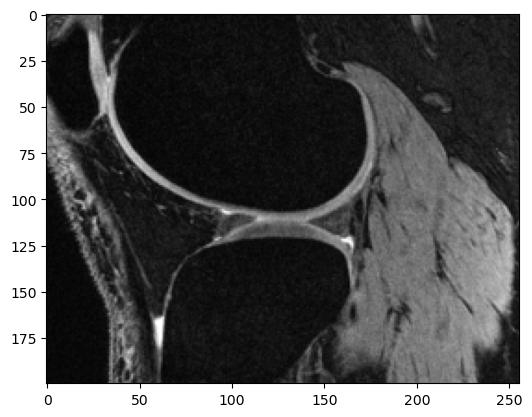

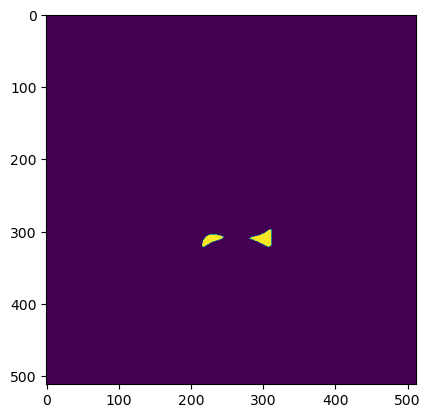

In [26]:
# turn to numpy and plot image and mask
np_im = image.squeeze(0).squeeze(0).numpy()
plt.imshow(np_im[...,100], cmap='gray')
plt.show()

np_mask = mask.squeeze(0).squeeze(0).numpy()
plt.imshow(np_mask[...,100])
plt.show()

In [27]:
model_dir = home_dir+'/CDT_no_icloud/model_saves/'
model_path = 'unet_with_aug_all_data_bs4_60e_best_E.pth'

In [30]:
unet = UNet3D(1, 1, 16)
#load trained model
PATH = model_dir + model_path
state_dict = torch.load(PATH, map_location=device)

# Sometimes, the model dictionary keys contain 'module.' prefix which we don't want
remove_prefix = True

if remove_prefix:
    remove_prefix = 'module.'
    state_dict = {k[len(remove_prefix):] if k.startswith(remove_prefix) else k: v for k, v in state_dict.items()}

unet.load_state_dict(state_dict)
unet.eval();


In [31]:
out = unet(image)

In [32]:
out.shape

torch.Size([1, 1, 200, 256, 160])

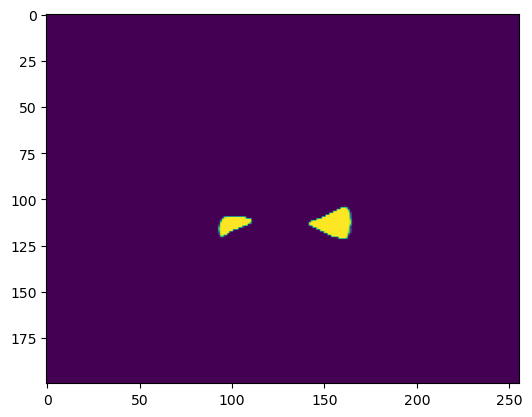

In [34]:
np_pred = out.squeeze(0).squeeze(0).detach().numpy()
plt.imshow(np_pred[...,100])
plt.show()

In [35]:
# Turn to a binary mask
pred_binary = (np_pred>0.5).astype(int)

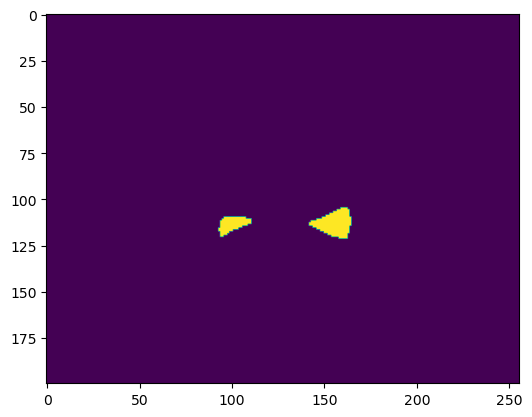

In [36]:
plt.imshow(pred_binary[...,100])
plt.show()

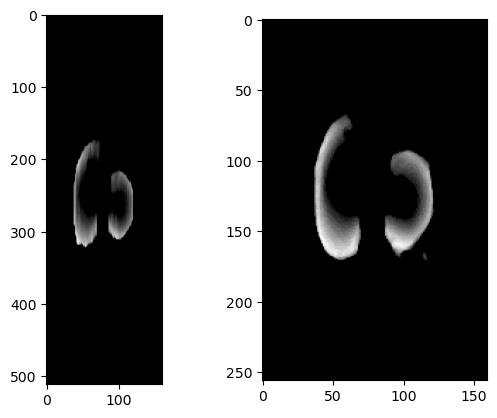

In [41]:
# show proj view from above
fig, ax = plt.subplots(1, 2)

ax[0].imshow(np.sum(np_mask, axis=0), cmap = 'gray')
ax[1].imshow(np.sum(pred_binary, axis=0), cmap = 'gray')


In [42]:
def undo_crop(cropped_image):
    # Original dimensions
    original_shape = (384, 384, 160)
    
    # Cropping indices from the crop_im function
    dim1_lower, dim1_upper = 120, 320
    dim2_lower, dim2_upper = 70, 326
    
    # Initialize a zero array with the original shape
    padded_image = np.zeros(original_shape, dtype=cropped_image.dtype)
    
    # Place the cropped image in the correct location within the zero-padded array
    padded_image[dim1_lower:dim1_upper, dim2_lower:dim2_upper, :] = cropped_image
    
    return padded_image

In [60]:
# Undo the crop
padded_pred = undo_crop(pred_binary)

# Resize to 512, 512, 160
pred_tensor = torch.tensor(padded_pred).unsqueeze(0).unsqueeze(0).float()  # Shape: (1, 1, 384, 384, 160)
resized_pred_t = F.interpolate(pred_tensor, size=(512, 512, 160), mode='trilinear', align_corners=True).round().long()


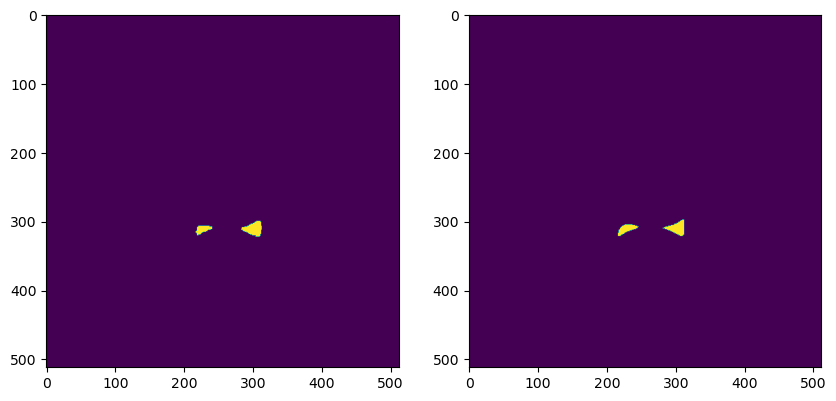

In [61]:
# compare the gt and the pred
fig, ax = plt.subplots(1, 2, figsize = (10,5))

ax[0].imshow(resized_pred_t.squeeze(0).squeeze(0).numpy()[...,100])
ax[1].imshow(mask.squeeze(0).squeeze(0).numpy()[...,100])
plt.show()

In [65]:
print(f"Dice score of {100 * dice_coefficient(mask, resized_pred_t):.2f}%")

Dice score of 78.56%
